# Decision making under uncertainty

In this lecture, you learned about how the Markov decision process (MDP) framework can be extended to allow uncertainty about the states. This can be used to model a wide range of decision-making problems where there is uncertainty or noise associated with the state of the world.

We considered the example of the random dot motion discrimination task, where a subject must indicate the direction in which the majority of dots are moving. In this assignment, you will solve a two-stage formulation of this task, where the decision-maker can either make an immediate decision (i.e., at the first stage) on the basis of initial information, or choose to wait and gather further information before making their choice (i.e., at the second stage). The complete description of the problem can be found in the lecture slides and also in the original paper: http://www.gatsby.ucl.ac.uk/~dayan/papers/NDM002wc.pdf

Your task is to reproduce the plots from Figure 9 of the paper, interpret the results, and explain the steps of the solution.

## 0. Define the parameters of the model (0.5 pts)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
# INSERT CODE HERE
# discritze the observation which is continuous in reality
step = 0.1 # discretization step
c = np.arange(0,10+step,step) # possible observations at each states

# likelihood distribution - 1 and 3 share the same parameters, 2 and 4 share the same parameters
mu_3 = 6
sig_3 = 1
mu_4 = 4
sig_4 = 1

##### ** One note: I used $c_a$ and $c_b$ for $c_{\alpha}$ and $c_{\beta}$ on the answers and plots. **

## 1. Updating the belief state  (2.5 pts)
The actual direction of motion ('state') is not completely observable to the subject. Hence, the subject can only rely on observations to compute the *belief* that the direction of motion is left or right (this is the posterior probability or 'belief state'). 

### 1a. Write a function that will calculate this posterior given the prior belief and an observation (the belief update). (0.5 pt)

In [3]:
# INSERT CODE BELOW
def belief_update_first(pre_blf,c_b,mu_3=mu_3,sig_3=sig_3,mu_4=mu_4,sig_4=sig_4):
    '''
    input:
    pre_blf: prior_belief, as a vector with two elements - [prior_belief of state 3, prior_belief of state 4]
    c_b: observation at the first stage
    mu_3, sig_3: mean and std of the likelihood at stage 3, fixed input
    mu_4, sig_4: mean and std of the likelihood at stage 4, fixed input

    output:
    pos_blf: posterior belief state as a vector with two elements - [posterior_belief of state 3, posterior_belief of state 4]
    '''
    pos_blf = np.zeros(2)
    likelihood_ratio = norm.pdf(c_b, loc=mu_3, scale=sig_3) / norm.pdf(c_b, loc=mu_4, scale=sig_4) # l(c_b) = p(c_b|x3) / p(c_b|x4)
    pos_blf[0] = 1 / (1 + 1 / (likelihood_ratio*pre_blf[0]/pre_blf[1]))
    assert pos_blf[0] >= 0
    assert pos_blf[0] <= 1
    pos_blf[1] = 1-pos_blf[0]
    
    return pos_blf

### 1b. Use this function to update the belief on the first observation at step $\beta$ and reproduce Fig 9A.  Interpret the plot. (1 pt)

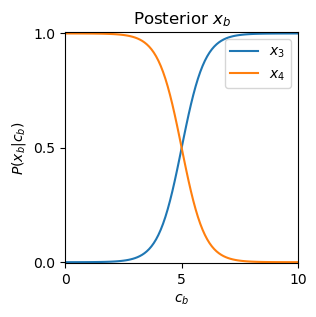

In [4]:
# INSERT CODE BELOW
prior_belief = np.array([.5, .5])
c = np.arange(0,10+step,step)
posterior_belief_1 = np.zeros((len(c),2))
for i,c_a in enumerate(c):
    posterior_belief_1[i,:] = belief_update_first(prior_belief,c_a)

fig,ax = plt.subplots(figsize=(3,3))
fig = ax.plot(posterior_belief_1[:,0],label="$x_3$")
fig = ax.plot(posterior_belief_1[:,1],label="$x_4$")
ax.set_xlabel("$c_b$")
ax.set_xticks([0,int(5/step),int(10/step)],[0,5,10])
ax.set_xlim([0,int(10/step)])
ax.set_ylabel("$P(x_b|c_b)$")
ax.set_yticks([0,0.5,1])
ax.set_ylim([-0.005,1.005])
ax.set_title("Posterior $x_b$")
ax.legend();

INSERT ANSWER BELOW

The plot itself is the graphical implementation of the belief state, which is solely determined by the likelihood ratio here, as the prior probabilites are fixed at 0.5 for the both possible states. From here, we can see that the error is likely to occur when the observation is uncertain ($c_b$ around 5), and as the observation gets closer to 0 or 10 from 5, the error is unlikely to occur, which we can already expect from the conditional distributions over the possible observations (likelihood distribution). 

### 1c. Write a function to update the belief on observing another sample at step $\alpha$ and reproduce Fig 9B.  Interpret the plot. (1 pt)
Hint: You will have to calculate this probability for every possible pair of observations.

In [5]:
# INSERT CODE BELOW
def belief_update_second(pos_blf_first,c_a,mu_1=mu_3,sig_1=sig_3,mu_2=mu_4,sig_2=sig_4):
    '''
    input:
    pos_blf_first: posterior belief from the first stage, this is the prior of the second stage
    c_a: observation at the second stage
    mu_1, sig_2: mean and std of the likelihood at stage 1, fixed input
    mu_2, sig_2: mean and std of the likelihood at stage 2, fixed input

    output:
    pos_blf_second: posterior belief of the second stage for the given observation
    '''
    # assign an array for the posterior belief
    pos_blf_second = np.zeros((2,len(pos_blf_first))) # [state(1 or 2),c_b]
    # compute posterior belief for the state 1
    p_cax1 = norm.pdf(c_a, loc=mu_1, scale=sig_2) 
    pos_blf_second[0,:] = p_cax1*pos_blf_first[:,0]
    # compute posterior belief for the state 2
    p_cax2 = norm.pdf(c_a, loc=mu_2, scale=sig_2)
    pos_blf_second[1,:] = p_cax2*pos_blf_first[:,1]
    # renormalize
    for i in range(len(c)):
        p1,p2 = pos_blf_second[0,i],pos_blf_second[1,i]
        pos_blf_second[0,i] = p1/(p1+p2)
        pos_blf_second[1,i] = 1-p1/(p1+p2)

    return pos_blf_second

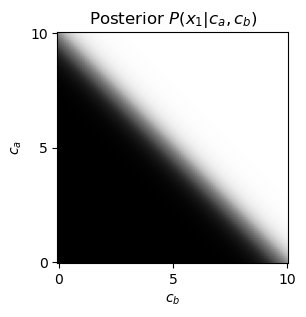

In [6]:
posterior_belief_2 = np.zeros((2,len(c),len(c)))
for i,c_a in enumerate(c):
    posterior_belief_2[:,i,:] = belief_update_second(posterior_belief_1,c_a)

fig,ax = plt.subplots(figsize=(3,3))
fig = ax.imshow(posterior_belief_2[0,:,:],origin="lower",cmap="Greys_r",vmin=0,vmax=1)
ax.set_xlabel("$c_b$")
ax.set_xticks([0,int(5/step),int(10/step)],[0,5,10])
ax.set_ylabel("$c_a$")
ax.set_yticks([0,int(5/step),int(10/step)],[0,5,10])
ax.set_title("Posterior $P(x_1|c_a,c_b)$");

INSERT ANSWER BELOW

As this plot is the posterior distribution for the state x1, only the posterior distribution of the state x3 contributes to it. From the equation to calculate this, the plot is just the result of multiplying the likelihood distributions of the state x1 and x3 and renormalizing them so that the sum of $P(x_1|c_a,c_b)$ and $P(x_2|c_a,c_b)$ is 1. This can be interpreted as the 1-dimensional posterior distribution from the one observation is extended to 2-dimensinal posterior distribution.

## 2. Solving for the optimal actions (7 pts)
Now that we have a way to update the belief states, we can use them to determine the best course of action at each of the steps (the 'optimal policy'). 

### 2a. When finding the optimal policy, why does it make sense to calculate the best action at the final stage $\alpha$, and work backwards? (1 pt)

INSERT ANSWER BELOW

At the state x3 or x4 and choose the action C, one should consider not only the action, but also the subsequent action at the x1 or x2. Therefore, it is necessary to calculate the best action at the final stage first and work backwards. As the given task has the Markov structure (the present state does not affect the choices at the past states), calculating the best action value at the final stage is sufficient to choose the best action at at the first stage, by using these best action values as the surrogates rewards at the first stage.

### 2b. Write a function that will calculate the value of the best action at $\alpha$ and reproduce Fig 9C. Explain what the plot shows. (1 pt)

In [7]:
# INSERT CODE BELOW
def best_value(pos_blf_second):
    '''
    input:
    pos_blf_second: posterior belief after the second stage

    output:
    best_val: maximum value for each pair of subsequent observatoins
    '''
    best_val = np.zeros((pos_blf_second.shape[1],pos_blf_second.shape[2])) # (c_a,c_b)
    for i in range(pos_blf_second.shape[1]):
        for j in range(pos_blf_second.shape[2]):
            best_val[i,j] = max(pos_blf_second[0,i,j],pos_blf_second[1,i,j])
    
    return best_val

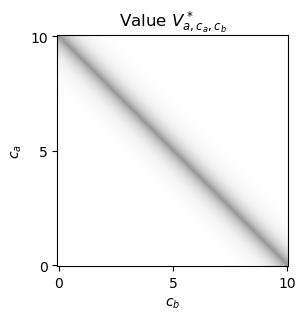

In [8]:
max_value = best_value(posterior_belief_2)

fig,ax = plt.subplots(figsize=(3,3))
fig = ax.imshow(max_value,origin="lower",cmap="Greys_r",vmin=0,vmax=1)
ax.set_xlabel("$c_b$")
ax.set_xticks([0,int(5/step),int(10/step)],[0,5,10])
ax.set_ylabel("$c_a$")
ax.set_yticks([0,int(5/step),int(10/step)],[0,5,10])
ax.set_title("Value $V^*_{a,c_a,c_b}$");

INSERT ANSWER BELOW

As the equation to calculate this value suggests, this is the maximum value of the two posteriors at the final stage. This suggests that the subject will make the most error when the sum of the two observations are around 10.

### 2c. Before finding the best action at $\beta$, we have one more step to do. We need the values of the best actions at $\alpha$ that we just calculated and the probability of observing $c_{\alpha}$ given $c_{\beta}$ ($P(c_{\alpha} | c_{\beta})$). Why? (1 pt)

INSERT ANSWER BELOW

The subject has to decide whether to choose C or not at the first stage, before observing $c_a$. This requires to average the values of the best actions at $\alpha$ over $c_a$ (all possible observation). However, as the subject already observed $c_b$, the possibility to observe $c_a$ is given as the conditional possbility $P(c_a|c_b)$. Therefore, we need the values of the best actions at $\alpha$ that we just calculated and the probability of observing $c_a$ given $c_b$.


### 2d. Write a function that will calculate $P(c_{\alpha} | c_{\beta})$ and reproduce Fig 9D. Explain how you calculated this probability and what the plot shows. (1 pt)
Hint: You will have to marginalise the posteriors over the possible states.

In [9]:
# INSERT CODE BELOW
def prob_ca_cb(pos_blf_1,c=c,mu_1=mu_3,sig_1=sig_3,mu_2=mu_4,sig_2=sig_4):
    '''
    input:
    pos_blf_1: posterior belief from the first stage
    c: observation axis, fixed ipnut
    mu_1, sig_1: mean and std of the likelihood at stage 1, fixed input
    mu_2, sig_2: mean and std of the likelihood at stage 2, fixed input

    output:
    prob_ab: the probabilty of observing c_a given c_b
    '''
    prob_ab = np.zeros((c.shape[0],c.shape[0])) # [c_a,c_b]
    
    for i,c_b in enumerate(c):
        blf_x3 = pos_blf_1[i,0]
        blf_x4 = pos_blf_1[i,1]
        for j,c_a in enumerate(c):
            p_cax1 = norm.pdf(c_a, loc=mu_1, scale=sig_1)
            p_cax2 = norm.pdf(c_a, loc=mu_2, scale=sig_2)
            prob_ab[j,i] = blf_x3*p_cax1+blf_x4*p_cax2

    for i in range(len(c)):
        prob_ab[:,i] = prob_ab[:,i]/np.sum(prob_ab[:,i]) # renormalization, sum of p(c_a|c_b) over c_a for each c_b should be 1

    return prob_ab

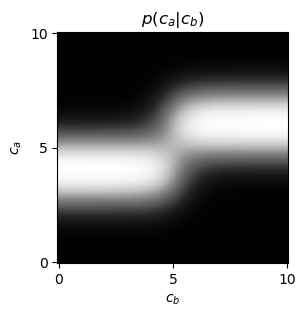

In [10]:
prob_ab = prob_ca_cb(posterior_belief_1)

fig,ax = plt.subplots(figsize=(3,3))
fig = ax.imshow(prob_ab,origin="lower",cmap="Greys_r")
ax.set_xlabel("$c_b$")
ax.set_xticks([0,int(5/step),int(10/step)],[0,5,10])
ax.set_ylabel("$c_a$")
ax.set_yticks([0,int(5/step),int(10/step)],[0,5,10])
ax.set_title("$p(c_a|c_b)$");

INSERT ANSWER BELOW

How I calcultated: The transition only happens x3 to x1 or x4 to x2. Therefore, we only have consider two cases. And for each case, as the two stages are independent, we can simply multiply the possiblities. The possiblities that I used are $P(x_b|c_b)$ and $p(c_a|x_a)$. The reason is that for the first stage, the subject is already observed, and for the second stage, the subject is guessing over the possible observation according to its true state. Then, at the end, I renormalize the distribution for each $c_b$.

The meaning of the plot: When you observe the plot from the y-axis, the plot is the overlaying of the two likelihood distributions. As the posteriors of the first stage have the higher value for the $x_4$ between 0 to 5 and for the $x_3$ between 5 to 10, the plot has the following transition centered around 5.

### 2e. We are now ready to find the best action at $\beta$. Write a function that calculates the values associated with each of the actions and reproduce Fig 9E. What does the plot tell you about what the best action is at $\beta$? (1 pt)
Hint: For action C, you will have to numerically integrate over possible observations ${c_{\alpha}}$ using the step size ($dc_{\alpha}$) you defined on your Gaussian observation distribution. 

In [12]:
# INSERT CODE BELOW
def get_Q_value(pos_blf_1,max_val,c=c,step=step,mu_1=mu_3,sig_1=sig_3,mu_2=mu_4,sig_2=sig_4,neg_reward=-0.1):
    '''
    input:
    pos_blf_1: posterior belief after the first stage (P(x3|cb) and P(x4|cb))
    max_val: the value of the best action 
    c: observation axis, fixed input
    step: step size of the observation axis, fixed input
    mu_1, sig_1: mean and std of the likelihood at stage 1, fixed input
    mu_2, sig_2: mean and std of the likelihood at stage 2, fixed input

    output:
    Q: Q-value for each action at each state
    '''
    # assign an array to save Q-values
    Q = np.zeros((3,len(c))) # [L,R,C]
    # for action L or R
    Q[0,:] = pos_blf_1[:,0]
    Q[1,:] = pos_blf_1[:,1]
    # for action C
    V = np.zeros(len(c))
    p_cax1 = norm.pdf(c, loc=mu_1, scale=sig_1)
    p_cax2 = norm.pdf(c, loc=mu_2, scale=sig_2)
    for i in range(len(c)):
        V[i] = pos_blf_1[i,0]*np.sum(max_val[:,i]*p_cax1*step)+pos_blf_1[i,1]*np.sum(max_val[:,i]*p_cax2*step)
    
    Q[2,:] = neg_reward+V

    return Q

In [13]:
# to compute the ragne of the observations at b need to do C, related to the next question
def range_action_C(q_val,step=step):
    '''
    input:
    q_val: Q values
    step: step size of the observation axis, fixed input

    output:
    range_cb: range of obsrvations at b to do the action C
    '''
    q_C = q_val[2,:]
    q_LR = np.max(q_val[0:2,:],axis=0)

    start = 0
    end = 0
    flag = 0 
    for i in range(len(q_C)):
        if q_C[i] >= q_LR[i]:
            if flag == 0:
                flag = 1
                start = i
        if q_C[i] < q_LR[i]:
            if flag == 1:
                flag = 0
                end = i

    range_cb = (end-start)*step

    return range_cb

The range to wait: 1.3


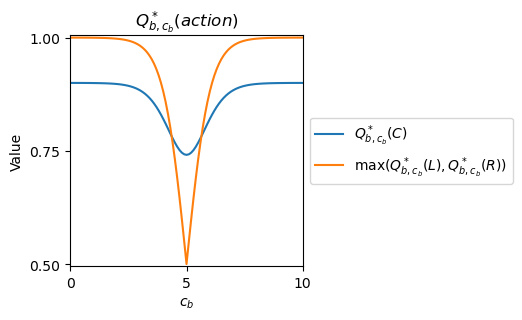

In [14]:
q_val = get_Q_value(posterior_belief_1,max_value)

fig,ax = plt.subplots(figsize=(3,3))
fig = ax.plot(q_val[2,:],label="$Q^*_{b,c_b}(C)$")
fig = ax.plot(np.max(q_val[0:2,:],axis=0),label="max($Q^*_{b,c_b}(L),Q^*_{b,c_b}(R)$)")
ax.set_xlabel("$c_b$")
ax.set_xticks([0,int(5/step),int(10/step)],[0,5,10])
ax.set_xlim([0,int(10/step)])
ax.set_ylabel("Value")
ax.set_yticks([0.5,0.75,1.0])
ax.set_title("$Q^*_{b,c_b}(action)$")
ax.set_ylim(0.495,1.005)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

print("The range to wait: {:.1f}".format(range_action_C(q_val)))

INSERT ANSWER BELOW

This plot means that if your observation is around 5, the best action you can take at $\beta$ is to choose the action C, otherwise choose the action L or R. This result matches with the likelihood distribution, as the observation around 5 gives the most uncertain guessing about the state $x_b$ that the subject can be in at the first stage.

### 2f. What will reduce (or increase) the range of observations at $\beta$ where it is best to choose to wait for another observation (choosing C)? Can you tweak a parameter to do this and produce a plot similar to Fig 9E to show this? (2 pts)
Hint: You will have to re-run the steps with this changed parameter. 

First, let's try to decrease the overlapping area of the likelihood distribution. This will lower the uncertainty at the first stage, hence will reduce the range of obserbations at $\beta$. This can be done by 1) lowering the standard deviation, and 2) increase the distance between the means higher.

The range to wait: 0.9


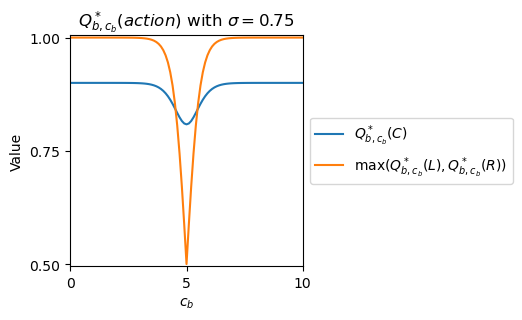

In [15]:
# Lower standard deviation
mu_3 = 6
sig_3 = 0.75
mu_4 = 4
sig_4 = 0.75

prior_belief = np.array([.5, .5])
c = np.arange(0,10+step,step)
posterior_belief_1 = np.zeros((len(c),2))
for i,c_a in enumerate(c):
    posterior_belief_1[i,:] = belief_update_first(prior_belief,c_a,mu_3=mu_3,sig_3=sig_3,mu_4=mu_4,sig_4=sig_4)

posterior_belief_2 = np.zeros((2,len(c),len(c)))
for i,c_a in enumerate(c):
    posterior_belief_2[:,i,:] = belief_update_second(posterior_belief_1,c_a,mu_1=mu_3,sig_1=sig_3,mu_2=mu_4,sig_2=sig_4)

max_value = best_value(posterior_belief_2)

prob_ab = prob_ca_cb(posterior_belief_1,mu_1=mu_3,sig_1=sig_3,mu_2=mu_4,sig_2=sig_4)

q_val = get_Q_value(posterior_belief_1,max_value,mu_1=mu_3,sig_1=sig_3,mu_2=mu_4,sig_2=sig_4)

fig,ax = plt.subplots(figsize=(3,3))
fig = ax.plot(q_val[2,:],label="$Q^*_{b,c_b}(C)$")
fig = ax.plot(np.max(q_val[0:2,:],axis=0),label="max($Q^*_{b,c_b}(L),Q^*_{b,c_b}(R)$)")
ax.set_xlabel("$c_b$")
ax.set_xticks([0,int(5/step),int(10/step)],[0,5,10])
ax.set_xlim([0,int(10/step)])
ax.set_ylabel("Value")
ax.set_yticks([0.5,0.75,1.0])
ax.set_title("$Q^*_{b,c_b}(action)$ with $\sigma = 0.75$")
ax.set_ylim(0.495,1.005)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

print("The range to wait: {:.1f}".format(range_action_C(q_val)))

The range to wait: 1.1


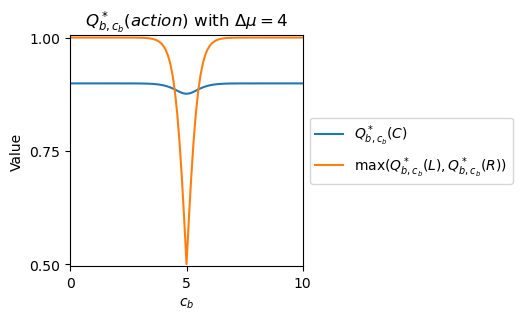

In [16]:
# Larger distance between the means
mu_3 = 7
sig_3 = 1
mu_4 = 3
sig_4 = 1

prior_belief = np.array([.5, .5])
c = np.arange(0,10+step,step)
posterior_belief_1 = np.zeros((len(c),2))
for i,c_a in enumerate(c):
    posterior_belief_1[i,:] = belief_update_first(prior_belief,c_a,mu_3=mu_3,sig_3=sig_3,mu_4=mu_4,sig_4=sig_4)

posterior_belief_2 = np.zeros((2,len(c),len(c)))
for i,c_a in enumerate(c):
    posterior_belief_2[:,i,:] = belief_update_second(posterior_belief_1,c_a,mu_1=mu_3,sig_1=sig_3,mu_2=mu_4,sig_2=sig_4)

max_value = best_value(posterior_belief_2)

prob_ab = prob_ca_cb(posterior_belief_1,mu_1=mu_3,sig_1=sig_3,mu_2=mu_4,sig_2=sig_4)

q_val = get_Q_value(posterior_belief_1,max_value,mu_1=mu_3,sig_1=sig_3,mu_2=mu_4,sig_2=sig_4)

fig,ax = plt.subplots(figsize=(3,3))
fig = ax.plot(q_val[2,:],label="$Q^*_{b,c_b}(C)$")
fig = ax.plot(np.max(q_val[0:2,:],axis=0),label="max($Q^*_{b,c_b}(L),Q^*_{b,c_b}(R)$)")
ax.set_xlabel("$c_b$")
ax.set_xticks([0,int(5/step),int(10/step)],[0,5,10])
ax.set_xlim([0,int(10/step)])
ax.set_ylabel("Value")
ax.set_yticks([0.5,0.75,1.0])
ax.set_title("$Q^*_{b,c_b}(action)$ with $\Delta\mu = 4$")
ax.set_ylim(0.495,1.005)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

print("The range to wait: {:.1f}".format(range_action_C(q_val)))

As one can check from the two plots above, implementing the two cases achieved the reduction of the range of observations at $\beta$ to choose C. I also calculate the range numerically, and one can check that in these two cases, it is lower than 1.3, which is the case with the original parameters.

Intuitively, changing the parameters in reverse from what I did above should increase the range of observations. However, this is not the case when the distance between the means are smaller. Here is the example.

The range to wait: 0.9


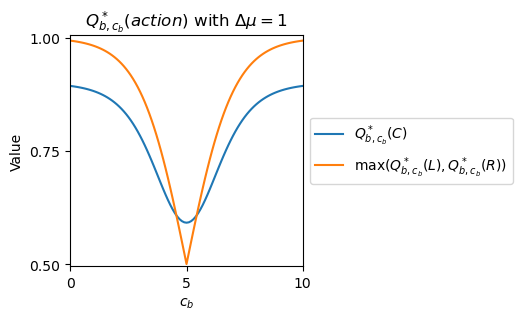

In [17]:
# Smaller distance between the means
mu_3 = 5.5
sig_3 = 1
mu_4 = 4.5
sig_4 = 1

prior_belief = np.array([.5, .5])
c = np.arange(0,10+step,step)
posterior_belief_1 = np.zeros((len(c),2))
for i,c_a in enumerate(c):
    posterior_belief_1[i,:] = belief_update_first(prior_belief,c_a,mu_3=mu_3,sig_3=sig_3,mu_4=mu_4,sig_4=sig_4)

posterior_belief_2 = np.zeros((2,len(c),len(c)))
for i,c_a in enumerate(c):
    posterior_belief_2[:,i,:] = belief_update_second(posterior_belief_1,c_a,mu_1=mu_3,sig_1=sig_3,mu_2=mu_4,sig_2=sig_4)

max_value = best_value(posterior_belief_2)

prob_ab = prob_ca_cb(posterior_belief_1,mu_1=mu_3,sig_1=sig_3,mu_2=mu_4,sig_2=sig_4)

q_val = get_Q_value(posterior_belief_1,max_value,mu_1=mu_3,sig_1=sig_3,mu_2=mu_4,sig_2=sig_4)

fig,ax = plt.subplots(figsize=(3,3))
fig = ax.plot(q_val[2,:],label="$Q^*_{b,c_b}(C)$")
fig = ax.plot(np.max(q_val[0:2,:],axis=0),label="max($Q^*_{b,c_b}(L),Q^*_{b,c_b}(R)$)")
ax.set_xlabel("$c_b$")
ax.set_xticks([0,int(5/step),int(10/step)],[0,5,10])
ax.set_xlim([0,int(10/step)])
ax.set_ylabel("Value")
ax.set_yticks([0.5,0.75,1.0])
ax.set_title("$Q^*_{b,c_b}(action)$ with $\Delta\mu = 1$")
ax.set_ylim(0.495,1.005)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

print("The range to wait: {:.1f}".format(range_action_C(q_val)))

My guess about this result is, as the overlap between the likelihood distributions are too high, choosing C does not increase the total reward as much, as the chance of making a mistake is still high even after the second observation.

One more thing we can tweak is the reward that is given when choosing the action C. By lowering this, it will lower the value of choosing C. Therefore, I will reduce the range of observations at $\beta$ to choose C. I implemented this below.

The range to wait: 0.7


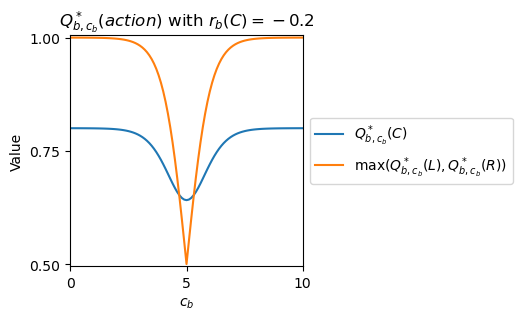

In [18]:
# with reward to choose C smaller than -0.1
mu_3 = 6
sig_3 = 1
mu_4 = 4
sig_4 = 1
reward_to_choose_C = -0.2

prior_belief = np.array([.5, .5])
c = np.arange(0,10+step,step)
posterior_belief_1 = np.zeros((len(c),2))
for i,c_a in enumerate(c):
    posterior_belief_1[i,:] = belief_update_first(prior_belief,c_a,mu_3=mu_3,sig_3=sig_3,mu_4=mu_4,sig_4=sig_4)

posterior_belief_2 = np.zeros((2,len(c),len(c)))
for i,c_a in enumerate(c):
    posterior_belief_2[:,i,:] = belief_update_second(posterior_belief_1,c_a,mu_1=mu_3,sig_1=sig_3,mu_2=mu_4,sig_2=sig_4)

max_value = best_value(posterior_belief_2)

prob_ab = prob_ca_cb(posterior_belief_1,mu_1=mu_3,sig_1=sig_3,mu_2=mu_4,sig_2=sig_4)

q_val = get_Q_value(posterior_belief_1,max_value,mu_1=mu_3,sig_1=sig_3,mu_2=mu_4,sig_2=sig_4,neg_reward=reward_to_choose_C)

fig,ax = plt.subplots(figsize=(3,3))
fig = ax.plot(q_val[2,:],label="$Q^*_{b,c_b}(C)$")
fig = ax.plot(np.max(q_val[0:2,:],axis=0),label="max($Q^*_{b,c_b}(L),Q^*_{b,c_b}(R)$)")
ax.set_xlabel("$c_b$")
ax.set_xticks([0,int(5/step),int(10/step)],[0,5,10])
ax.set_xlim([0,int(10/step)])
ax.set_ylabel("Value")
ax.set_yticks([0.5,0.75,1.0])
ax.set_title("$Q^*_{b,c_b}(action)$ with $r_b(C) = -0.2$")
ax.set_ylim(0.495,1.005)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

print("The range to wait: {:.1f}".format(range_action_C(q_val)))